In [1]:
import numpy as np
import plotly.express as px
from visualisation import plotly_utils as pu
import polars as pl
from tqdm import tqdm
from ornstein_ulhenback import estimate_OU_parameters

In [2]:
tickers = pl.read_csv("tickers_and_category.csv")
ticker_list = tickers["ticker"].to_list()

In [3]:
ou_calibrated = pl.DataFrame([estimate_OU_parameters(ticker) for ticker in tqdm(ticker_list)]).join(tickers, on="ticker")
grouped_by_category = ou_calibrated.group_by('category').agg(pl.col('theta').mean(), pl.col('sigma').mean(), pl.col('kappa').mean())

100%|██████████| 100/100 [00:12<00:00,  8.08it/s]


In [4]:
ou_calibrated.describe()

statistic,ticker,kappa,theta,sigma,vol0,category
str,str,f64,f64,f64,f64,str
"""count""","""100""",100.0,100.0,100.0,100.0,"""100"""
"""null_count""","""0""",0.0,0.0,0.0,0.0,"""0"""
"""mean""",null,73.87625,0.20494,0.76016,0.18304,null
"""std""",null,20.301211,0.14628,0.600353,0.129665,null
"""min""","""AAPL""",42.684885,0.033797,0.112158,0.022602,"""Agriculture"""
"""25%""",null,59.614827,0.107303,0.432099,0.089142,null
"""50%""",null,69.253852,0.18458,0.619345,0.155057,null
"""75%""",null,82.764158,0.241815,0.828273,0.213214,null
"""max""","""XRT""",151.334998,0.830536,3.437973,0.699992,"""Utilities"""


In [16]:
fig = px.bar(grouped_by_category.sort('kappa'), x='category', y='kappa')
pu.customize_plotly_chart(fig, font_family='fonts/GeistMono.ttf', color_palette="#434C5E" , x_label="Asset Class / Industry →", y_label="Kappa →", title="Strength of Mean Reversion", y_grid=False, width=1200, height=600)
fig.show()

In [17]:
fig = px.bar(grouped_by_category.sort('sigma'), x='category', y='sigma')
pu.customize_plotly_chart(fig, font_family='fonts/GeistMono.ttf',  color_palette="#434C5E", x_label="Asset Class / Industry", y_label="Sigma", title="META VOLATILITY", y_grid=False, width=1200, height=600)


In [18]:
fig = px.bar(grouped_by_category.sort('theta'), x='category', y='theta')
pu.customize_plotly_chart(fig, font_family='fonts/GeistMono.ttf',  color_palette="#434C5E", x_label="Asset Class / Industry →", y_label="Theta →", title="AMBIENT VOLATILITY", y_grid=False,width=1200, height=600)

In [20]:
from vol_utils import get_volatility_array
import scipy.stats as ss

def simulate_volatility_paths (ticker, X0=None):
   vol = get_volatility_array(ticker) * np.sqrt(252)
   N = 252
   dt = 1/252
   paths = 5000  # number of paths
   if X0 is None:
      X0 = vol[-1]
   X = np.zeros((N, paths))
   X[0, :] = X0
   W = ss.norm.rvs(loc=0, scale=1, size=(N - 1, paths))

   ticker, kappa, theta, sigma, vol0 = estimate_OU_parameters(ticker).values()

   for t in range(0,N-1):
      X[t + 1, :] = X[t, :] + kappa*(theta - X[t, :])*dt + sigma * np.sqrt(dt) * W[t, :]

   return X

def get_expected_number_of_days (ticker, X0=None):
   X = simulate_volatility_paths(ticker, X0)
   ticker, kappa, theta, sigma, vol0 = estimate_OU_parameters(ticker).values()
   dt = 1/252
   T_to_theta = np.argmax(X <= theta if (X0 > theta) else X >= theta, axis=0) * dt  # first passage time   
   expected_days = round(T_to_theta.mean() * 252,2)
   standard_error = round(ss.sem(T_to_theta) * 252,4)
   return {
      "ticker": ticker,
      "current_volatility": X0,
      "ambient_volatility": theta,
      "expected_days": expected_days,
      "standard_error": standard_error,      
   }



In [21]:
expected_days = pl.DataFrame([get_expected_number_of_days(ticker, 0.5) for ticker in ticker_list]).join(tickers, on='ticker')
grouped_expected_days = expected_days.group_by('category').agg(pl.col('current_volatility').mean(), pl.col('ambient_volatility').mean(), pl.col('expected_days').mean())


In [22]:
fig = px.bar(grouped_expected_days.sort('expected_days'), x='category', y='expected_days')
pu.customize_plotly_chart(fig, font_family='fonts/GeistMono.ttf',  x_label="Asset Class / Industry →", y_label="Expected Number of Trading Days →", title="EXPECTED NUMBER OF TRADING DAYS TO RETURN TO AMBIENT VOLATILITY STARTING FROM 0.5", y_grid=False, color_palette="#434C5E", width=1200, height=600)


In [24]:
fig = px.scatter(ou_calibrated, x="theta", y="kappa", text='ticker')
pu.customize_plotly_chart(fig, font_family='fonts/GeistMono.ttf', y_label="Mean Reversion Strength (κ) →",x_label="AMBIENT VOLATILITY (Θ) →", title="AMBIENT VOLATILITY vs MEAN REVERSION", y_grid=False, color_palette="#434C5E", width=1200)
fig.update_traces(textposition='middle right')

In [25]:
fig = px.scatter(ou_calibrated, x="kappa", y="sigma", text='ticker')
pu.customize_plotly_chart(fig, font_family='fonts/GeistMono.ttf', x_label="Mean Reversion Strength (κ) →", y_label="Meta Volatility (σ) →", title="META VOLATILITY vs MEAN REVERSION", y_grid=False, color_palette="#434C5E", width=1200)
fig.update_traces(textposition='middle right')


In [26]:
fig = px.scatter(ou_calibrated, x="theta", y="sigma", text='ticker')
pu.customize_plotly_chart(fig, font_family='fonts/GeistMono.ttf', x_label="Ambient Volatility (Θ) →", y_label="Meta Volatility (σ) →", title="META VOLATILITY vs AMBIENT VOLATILITTY", y_grid=False, color_palette="#434C5E", width = 1200)
fig.update_traces(textposition=f'middle right')


<module 'matplotlib.pyplot' from 'c:\\Users\\kumar\\AppData\\Local\\Programs\\Python\\Python312\\Lib\\site-packages\\matplotlib\\pyplot.py'>

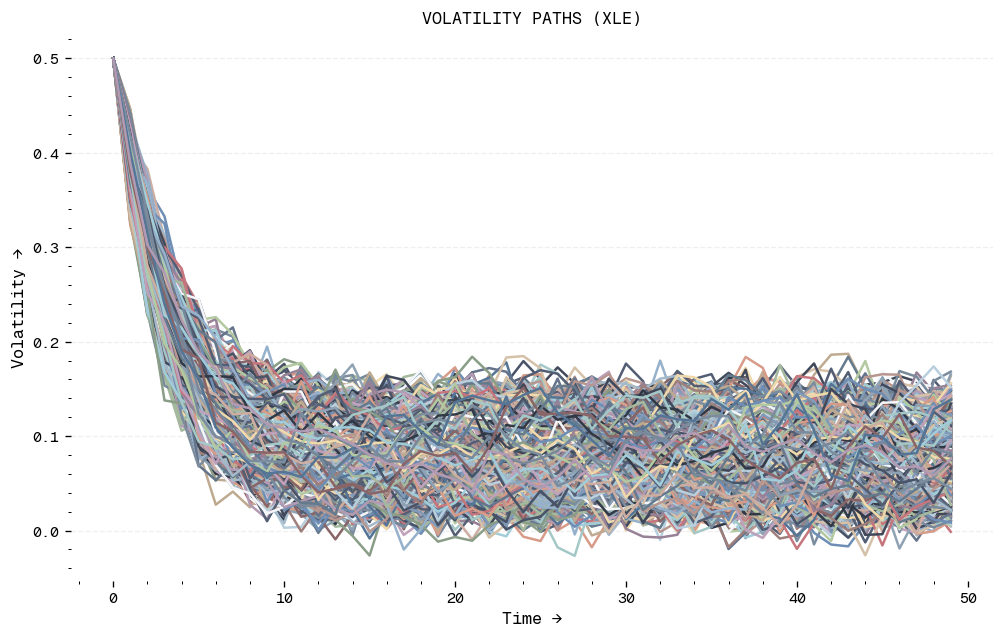

In [27]:
aapl = simulate_volatility_paths('TLT', 0.5)[:50]
import visualisation.matplotlib_charts as mu
from importlib import reload
reload(mu)
x = range(aapl.T.shape[1])
data = [(x, aapl.T[i], f"Path_{i}") for i in range(5000)]
mu.plot_multiline_chart(data=data, x_label="Time", y_label="Volatility", title="Volatility Paths (XLE)", legend=False)

In [102]:
get_expected_number_of_days('TLT', 0.5)

{'ticker': 'TLT',
 'current_volatility': 0.5,
 'ambient_volatility': 0.08047783314555018,
 'expected_days': 13.11,
 'standard_error': 0.071}